# Applied Data Analysis Project
**Team**: ToeStewBrr - Alexander Sternfeld, Marguerite Thery, Antoine Bonnet, Hugo Bordereaux

**Dataset**: CMU Movie Summary Corpus


## CoreNLP Analysis

[**CoreNLP**](https://nlp.stanford.edu/software/) is an incredible natural language processing toolkit created at Stanford University. CoreNLP is applied through a **pipeline** of sequential analysis steps called annotators. The full list of available annotators is available [here](https://stanfordnlp.github.io/CoreNLP/annotators.html). 

As described by its creators: 

*"CoreNLP is your one stop shop for natural language processing in Java! CoreNLP enables users to derive linguistic annotations for text, including token and sentence boundaries, parts of speech, named entities, numeric and time values, dependency and constituency parses, coreference, sentiment, quote attributions, and relations. CoreNLP currently supports 8 languages: Arabic, Chinese, English, French, German, Hungarian, Italian, and Spanish."* 

You can create your own pipeline to extract the desired information. You can try it out for yourself in this [online shell](https://corenlp.run).

### Loading data
We first load data files and download the pre-processed dataframes. 

In [1]:
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt

from load_data import *
from coreNLP_analysis import *

download_data(coreNLP=False)
plot_df = load_plot_df()
movie_df = load_movie_df()
char_df = load_char_df()
names_df = load_names_df()
cluster_df = load_cluster_df()

### 1. Exploring pre-processed CoreNLP data

The authors of the Movie CMU dataset used CoreNLP to parse each plot summary to extract various linguistic insights. In this section, we explore how much information we can gather from these pre-processed files. 

We will use *Harry Potter*'s character throughout this section.

#### 1.1. Character data

For any character, we first extract related information from the provided name clusters and character metadata.

In [ ]:
# Given character, extract all pre-processed dataframe data
char_name = 'Harry Potter'
movie_ids = list(char_df[char_df['Character name'] == char_name]['Wikipedia ID'])
char_ids = names_df.loc[char_name].values[0]
trope = cluster_df.loc[cluster_df['Character name'] == char_name]

# If no trope is found, set it to None
if trope.empty:
    trope = None

print('Movies with character', char_name, ':')
print('\tMovie IDs:', movie_ids)
print('\tCharacter IDs:', char_ids)
print('\tTrope:', trope)

movie_id = movie_ids[3] 
movie_name = movie_df.loc[movie_df['Wikipedia ID'] == movie_id]['Name'].iloc[0]
print('Selecting as example: \n\tMovie ID:', movie_id, '\n\tMovie title:', movie_name)


#### 1.2. Extracting sentences

We now extract information from the CoreNLP plot summary analysis. The authors of the dataset stored the analysis output of each movie into a `.xml` file. Each file has a tree structure detailing each word of each sentence as well as the parsed sentence in tree form. 

We now extract all parsed sentences from the `.xml` files. 

A **parsed sentence** is a syntactic analysis tree, where each word is a leaf tagged by its lexical function (e.g. *VBZ* for verbs or *DT* for determinants). Semantic interactions between different words are also indicated within the structure of the tree. 

In [ ]:
# Extract the tree of xml file and all parsed sentences
tree = get_tree(movie_id)
sentences = get_parsed_sentences(tree)

# Picking the fifth sentence as example
parsed_str = sentences[5]
print(parsed_str)
print_tree(parsed_str)

#### 1.3. Extracting characters

We also want to extract all character names directly from the xml file. Note that we aggregate consecutive words tagged as NNP (noun, proper, singular) as the same character name (this assumes that plot summaries never contain two distinct names side by side without delimiting punctuation). This is a reasonable assumption since list of names are almost always separated by commas. 

In [ ]:
characters = get_characters(tree)
print(characters[:20])

Notice that some characters are sometimes mentioned by their full name, and sometimes by a partial name (e.g. Harry Potter is most often mentioned as simply Harry). To get a more precise idea of how many times each character is mentioned, we wish to denote each character by their full name, i.e. the longest version of their name that appears in the plot summary. 

*NOTE*: The dataset has the character metadata of only a third of the movies, so we need to extract full names from the plot summary itself and not the provided dataframes. 

To optimize full name lookup, for each plot summary we construct a dictionary which stores as key every partial name mentioned, and as corresponding values the full name of each character.  

In [ ]:
char_name = 'Albus'
full_name = get_full_name(char_name, characters)
print('Example: the full name of "{}" is "{}".'.format(char_name,full_name))
print('Full name dictionary:', full_name_dict(characters))

We can now extract the most mentioned characters in any plot summary, in descending order of frequency. We can then see that Harry Potter is indeed the main character of the movie, as he is mentioned 26 times, more than any other character in the summary.  

In [ ]:
char_mentions = most_mentioned(movie_id)
print(char_mentions)

 #### 1.4. Extracting interactions

We are also interested in character interactions. We can use the number of common mentions of two characters in the same sentence as a proxy for the number of interactions. For any movie, we find the number of common mentions (i.e. interactions) for each pair of characters. 

In [ ]:
char_pairs = character_pairs(movie_id, plot_df)
print(char_pairs[:10])

In [ ]:
main_interaction = character_pairs(movie_id, plot_df)[0][0]
print('Main interaction in the movie:', main_interaction)

#### 1.5. Extracting characters and interactions of all movies

We will now use the above code to obtain the main character and main interaction for every plot summary. 

*NOTE*: This code takes a while to run, so you can load the analysis from a pre-processed file instead.  

In [ ]:
# NOTE: If we've already run this code, we can load the dataframe from a file
pairs_df = pd.read_csv('Data/MovieSummaries/plot_characters.csv', sep='\t', index_col=0)
pairs_df

In [ ]:
# Otherwise: get main character and number of mentions for each movie and store it into a file (takes a while to run) 
pairs_df = plot_df.copy(deep=True)
pairs_df['Main character'] = pairs_df['Wikipedia ID'].apply(most_mentioned)
pairs_df['Number of mentions'] = pairs_df['Main character'].apply(lambda x: np.nan if x is None else x[0][1])
pairs_df['Main character'] = pairs_df['Main character'].apply(lambda x: np.nan if x is None else x[0][0])

# Get main pairs of characters for each movie and number of interactions 
pairs_df['Main interaction'] = pairs_df['Wikipedia ID'].apply(lambda x: character_pairs(x, plot_df))
pairs_df['Number of interactions'] = pairs_df['Main interaction'].apply(lambda x: np.nan if x is None else x[0][1])
pairs_df['Main interaction'] = pairs_df['Main interaction'].apply(lambda x: np.nan if x is None else x[0][0])

# Store data into csv file
pairs_df.to_csv('Data/MovieSummaries/plot_characters.csv', sep='\t')
pairs_df

In conclusion, the coreNLP files provided with the datasets are useful to extract the characters mentioned. 

 However, our goal is to extract love relationships as well as the persona of characters in love. Using common mentions as a proxy for love relationships is a vulgar approximation and so we must run our own NLP analysis on the plot summaries to extract useful information. 

### 2. Custom CoreNLP Analysis

We now use a **custom CoreNLP pipeline** to analyze the plot summaries. For now, due to the weakness of our available computing power, we only analyze romantic comedy movies. 


#### 2.1. Data preparation

We extract the romantic comedy plot summaries that we will pass through our pipeline and store them as `.txt` files to be able to run them through the new coreNLP pipeline. 

In [ ]:
# For later use: romance_genres = ['Romantic comedy', 'Romance Film', 'Romantic drama', 'Romantic fantasy', 'Romantic thriller']

# Get a dataframe with romantic movies and their corresponding plots
romance_genres = ['Romantic comedy'] 
rom_com_plots = get_plots(romance_genres, movie_df, plot_df)
#display(rom_com_plots)

# Store each plot summary as .txt file
for index, row in rom_com_plots.iterrows():
    # If directory doesn't exist, create it
    if not os.path.exists('Data/MovieSummaries/RomancePlots'):
        os.makedirs('Data/MovieSummaries/RomancePlots')
    with open("Data/MovieSummaries/RomancePlots/{}.txt".format(row['Wikipedia ID']), 'w') as f:
        if type(row['Summary']) == str:
            f.write(row['Summary'])
            f.close()

#### 2.2. Custom CoreNLP pipeline

Our custom pipeline consists of the following annotators: 

1. [Tokenization (tokenize)](https://stanfordnlp.github.io/CoreNLP/tokenize.html): Turns the whole text into tokens. 

2. [Parts Of Speech (POS)](https://stanfordnlp.github.io/CoreNLP/pos.html): Tags each token with part of speech labels (e.g. determinants, verbs and nouns). 

3. [Lemmatization (lemma)](https://stanfordnlp.github.io/CoreNLP/lemma.html): Reduces each word to its lemma (e.g. *was* becomes *be*). 

4. [Named Entity Recognition (NER)](https://stanfordnlp.github.io/CoreNLP/ner.html): Identifies named entities from the text, including characters, locations and organizations. 

5. [Constituency parsing (parse)](https://stanfordnlp.github.io/CoreNLP/parse.html): Performs a syntactic analysis of each sentence in the form of a tree. 

6. [Coreference resolution (coref)](https://stanfordnlp.github.io/CoreNLP/coref.html): Aggregates mentions of the same entities in a text (e.g. when 'Harry' and 'he' refer to the same person). 

7. [Dependency parsing (depparse)](https://stanfordnlp.github.io/CoreNLP/depparse.html): Syntactic dependency parser. 

8. [Natural Logic (natlog)](https://stanfordnlp.github.io/CoreNLP/natlog.html): Identifies quantifier scope and token polarity. Required as preliminary for OpenIE. 

9. [Open Information Extraction (OpenIE)](https://stanfordnlp.github.io/CoreNLP/openie.html): Identifies relation between words as triples *(subject, relation, object of relation)*. We use this to extract relationships between characters, as well as character traits. 

10. [Knowledge Base Population (KBP)](https://stanfordnlp.github.io/CoreNLP/kbp.html): Identifies meaningful relation triples. 


#### 2.3. Running our pipeline

We now run our own CoreNLP analysis on the plot summaries. This allows us to extract love relationships from the plot summaries much more accurately.

**Goal**: Run our custom CoreNLP pipeline. 

**Recommendation**: Be careful about memory storage (takes a lot of memory to run!)

**Prerequisite**: [java](https://www.java.com). 

**Installation steps**:
1. Download the CoreNLP toolkit [here](https://stanfordnlp.github.io/CoreNLP/download.html).

2. Change directory (`cd`) into the downloaded `stanford-corenlp` directory. 

3. Data preparation: Extract plot summaries for romantic comedies into `.txt` files. Create a filelist containing the name of all the files which need to be processed using the following command in your terminal: 

<center>find RomancePlots/*.txt > filelist.txt</center>
        
4. Run the custom CoreNLP pipeline via your terminal using the following command:

<center>java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLP -annotators tokenize,pos,lemma,ner,parse,coref,depparse,natlog,openie,kbp -coref.md.type RULE -filelist filelist.txt -outputDirectory RomancePlotsOutputs/ -outputFormat xml</center>

The analysis outputs are now stored as `.xml` files in the `RomancePlotsOutputs` directory. We now unzip them. RomancePlotsOutputs has 1491 readable files. 

In [ ]:
# Extract all the romance plots xml files
with ZipFile('Romance_Data/RomancePlotsOutputs.zip', 'r') as zipObj:
   zipObj.extractall('')

#### 2.4 Extracting insights 

Now that we have run our custom pipeline, we can use the output of the KBP Annotator to extract characters' roles and relationships.

In [3]:
title_df = get_relation_df(DIR = 'RomancePlotsOutputs/', relation_type = 'per:title')
# Have list of attributes for each character
title_df = title_df.groupby(['Wikipedia ID','Subject'])['Relation'].apply(', '.join).reset_index()  
display(title_df)
print("Number of unique movies from which characters' roles have been extracted:", len(title_df['Wikipedia ID'].unique()))

,Wikipedia ID,Subject,Relation
0,1002717,Delia Darrow,assistant
1,1002717,Fergie,Inspector
2,1002717,Gerda Caswell,assistant
3,1002717,Gloria Mundy,"librarian, manager"
4,1002717,Rachel Roberts,assistant
...,...,...,...
1904,4339865,Max de Mirecourt,writer
1905,4339865,Tam Tam,Princess
1906,4340003,Danny Miller,producer
1907,4340003,Max Corkle,messenger


Number of unique movies from which characters' roles have been extracted: 955


We have extracted 1909 characters' roles across 955 of the 1491 different romantic comedies. We explore the most common character roles.  

In [ ]:
# Plot the 10 most common character roles 
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(x='Relation', data=title_df, order=title_df.groupby(['Relation']).count().sort_values(by = 'Wikipedia ID', ascending=False).head(10).index, ax=ax)

ax.set_title('Most common character role in romance movies')
ax.set_ylabel('Number of characters')
xlabels = ['{}'.format(x) for x in title_df.groupby(['Relation']).count().sort_values(by = 'Wikipedia ID', ascending=False).head(10).index]
ax.set_xticklabels(xlabels)
ax.set_xlabel('')
sns.set_style('darkgrid')
sns.set_palette('flare')
plt.show()

We see that students is the most common role, followed by artistic roles (writer, actress, actor, reporter) and power roles (boss, owner, manager). 

We extract the love relationships from the KPB Annotator using 'per:spouse' filter. 

In [127]:
love_df = get_relation_df(DIR = 'RomancePlotsOutputs/', relation_type = 'per:spouse', confidence_threshold = 0.9)
display(love_df)
print("Number of unique movies from which romantic relationships have been identified:", len(love_df['Wikipedia ID'].unique()))

,Wikipedia ID,Subject,Relation
0,231486,Jake Perry,Melanie Smooter
1,231486,Melanie Smooter,Jake Perry
2,231486,Andrew,Melanie Smooter
3,231486,Melanie Smooter,Andrew
4,3875767,Penelope Wilhern,Vanderman
...,...,...,...
681,1367110,Susan,Johnny
682,1367110,Johnny,Susan
683,1367110,Mike,Joan
684,25954897,Madan,Mallika


Number of unique movies from which romantic relationships have been identified: 254


Out of the 1085 relationships identified by KBP annotator from 319 romantic comedies, we noticed some love relationships are mutual (Harry/Sally, Sally/Harry), while other are only unidirectional (Sally/Harry).

We also notice some relations are self-loving (Toula/Toula). 

In [128]:
print("Number of self-loving relationships:", love_df[love_df['Relation'] == love_df['Subject']].shape)

Number of self-loving relationships: (38, 3)


We remove self-loving relationships from our dataframe because we consider them as mistakes or at least not pertinent for our analysis.

In [129]:
love_df = love_df[love_df['Relation'] != love_df['Subject']]

We also notice some pronouns are identified as subjects which mislead the number of relationships in a movie. We want to obtain a dataframe where the subjects and objects of the relationship are characters in the movie.

We create a dataframe containing the list of all the characters appearing in a movie.

In [130]:
movie_characters = []
for id in love_df['Wikipedia ID'].unique():
    tree = get_tree_romance(id)
    characters = get_characters(tree)
    movie_characters.append((id, characters))

In [131]:
movie_characters_df = pd.DataFrame(movie_characters, columns=['Wikipedia ID', 'Characters'])    
movie_characters_df

,Wikipedia ID,Characters
0,231486,"[Melanie Smooter, Jake Perry, Jake, Melanie, C..."
1,3875767,"[Penelope Wilhern, Wilhern, Penelope, Penelope..."
2,1571083,"[Ann, David Smith, Robert Montgomery, Ann, Dav..."
3,1511944,"[Sophie, Julien, Sophie, Julien, Julien, Sophi..."
4,277148,"[Julianne Potter, Michael O'Neil, Michael, Kim..."
...,...,...
237,2748481,"[Kay, Barbara Latimer, Susan, Kay, Barbara, Su..."
238,15907225,"[Louise, Ian, Sara, Ian, Louise, Ian, Ian, Sar..."
239,3151934,"[Kay Hilliard, Steven, Crystal Allen, Kay, Kay..."
240,1367110,"[Mike, Susan, Mike, Susan, Hal, Susan, Susan, ..."


We merge this dataframe to our love_df to be able to access the characters' list of a movie from the love_df. 

In [133]:
love_cast_df = love_df.merge(movie_characters_df, on='Wikipedia ID')
love_cast_df

,Wikipedia ID,Subject,Relation,Characters
0,231486,Jake Perry,Melanie Smooter,"[Melanie Smooter, Jake Perry, Jake, Melanie, C..."
1,231486,Melanie Smooter,Jake Perry,"[Melanie Smooter, Jake Perry, Jake, Melanie, C..."
2,231486,Andrew,Melanie Smooter,"[Melanie Smooter, Jake Perry, Jake, Melanie, C..."
3,231486,Melanie Smooter,Andrew,"[Melanie Smooter, Jake Perry, Jake, Melanie, C..."
4,3875767,Penelope Wilhern,Vanderman,"[Penelope Wilhern, Wilhern, Penelope, Penelope..."
...,...,...,...,...
643,1367110,Susan,Johnny,"[Mike, Susan, Mike, Susan, Hal, Susan, Susan, ..."
644,1367110,Johnny,Susan,"[Mike, Susan, Mike, Susan, Hal, Susan, Susan, ..."
645,1367110,Mike,Joan,"[Mike, Susan, Mike, Susan, Hal, Susan, Susan, ..."
646,25954897,Madan,Mallika,"[Deepa, Madanagopal, Madan, Madan, Madan, Mada..."


We can now check if the subject and object are part of the characters' list of the movie and filter out relations which does not involve movie's characters.

In [137]:
# Filter out relations that are not between movie's characters
love_cast_df = love_cast_df.copy(deep=True)
love_cast_df['Subject in characters'] = love_cast_df.apply(lambda x: x['Subject'] in x['Characters'], axis=1)
love_cast_df['Relation in characters'] = love_cast_df.apply(lambda x: x['Relation'] in x['Characters'], axis=1)
love_cast_df = love_cast_df[love_cast_df['Subject in characters'] & love_cast_df['Relation in characters']]
love_cast_df

,Wikipedia ID,Subject,Relation,Characters,Subject in characters,Relation in characters,Number of relations
0,231486,Jake Perry,Melanie Smooter,"[Melanie Smooter, Jake Perry, Jake, Melanie, C...",True,True,4
1,231486,Melanie Smooter,Jake Perry,"[Melanie Smooter, Jake Perry, Jake, Melanie, C...",True,True,4
2,231486,Andrew,Melanie Smooter,"[Melanie Smooter, Jake Perry, Jake, Melanie, C...",True,True,4
3,231486,Melanie Smooter,Andrew,"[Melanie Smooter, Jake Perry, Jake, Melanie, C...",True,True,4
4,3875767,Penelope Wilhern,Vanderman,"[Penelope Wilhern, Wilhern, Penelope, Penelope...",True,True,2
...,...,...,...,...,...,...,...
643,1367110,Susan,Johnny,"[Mike, Susan, Mike, Susan, Hal, Susan, Susan, ...",True,True,3
644,1367110,Johnny,Susan,"[Mike, Susan, Mike, Susan, Hal, Susan, Susan, ...",True,True,3
645,1367110,Mike,Joan,"[Mike, Susan, Mike, Susan, Hal, Susan, Susan, ...",True,True,3
646,25954897,Madan,Mallika,"[Deepa, Madanagopal, Madan, Madan, Madan, Mada...",True,True,2


We want to analyze the distribution of the number of relations per movie. We expect to see a lot of movie with 2 love relationships. Indeed, since we look at romantic comedies, we assume there are two characters in love in the movie and that their love is reciprocal (Hally loves Sally and Sally loves Harry). 

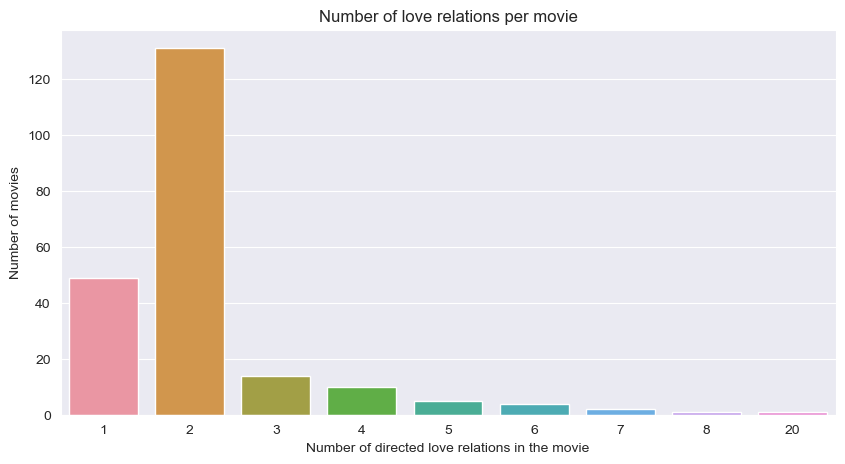

In [147]:
# Plot the distribution of the number of relations per movie
love_cast_df['Number of relations'] = love_cast_df.groupby(['Wikipedia ID'])['Relation'].transform('count')
# Obtain a dataframe with the number of relations per movie
relations_per_movie = love_cast_df[['Wikipedia ID', 'Number of relations']].drop_duplicates()

fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='Number of relations', data=relations_per_movie, ax=ax)
ax.set_title('Number of love relations per movie')
ax.set_ylabel('Number of movies')
ax.set_xlabel('Number of directed love relations in the movie')
sns.set_style('darkgrid')
sns.set_palette('flare')
plt.show()


As expected, we observe a high number of movies with 2 relationships. The number of movie with one relationship is quite high as well. We can interpret it as non-reciprocal love relations. 

We observe the cause of deaths of characters in romantic comedies. 

In [ ]:
death_df = get_relation_df(DIR = 'RomancePlotsOutputs/', relation_type = 'per:cause_of_death', confidence_threshold = 0.5)
death_df.groupby(['Relation']).count().sort_values(by = 'Wikipedia ID', ascending=False)[:10]

We see that heart attacks is the second most common cause of death. 

In [ ]:
age_df = get_relation_df(DIR = 'RomancePlotsOutputs/', relation_type = 'per:age', confidence_threshold=0.5)
age_df